This notebook demonstrates the local optimization of a filter coupled to a W thermal emitter,
and should reproduce the efficiency reported in Table II "W + F$_{opt}$" in 
"Accelerating the discovery of multi-layer nanostructures with analytic differentiation 
of the transfer matrix equations" by J. F. Varner, D. Wert, A. Matari, R. Nofal, and J. J. Foley IV.

  Gradient will be taken with respect to all layers! 


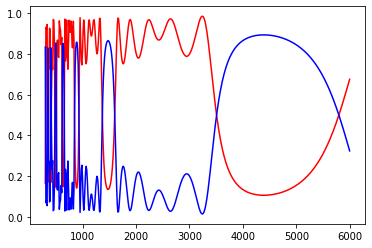

 Filter FOM 217.04445526587529
length is  5
grad is  [-4414713.03178024 -3180728.1981831  -6099294.3628404  -2440797.37509464
 -2459784.18178634]


In [3]:
from wptherml.wpml import multilayer
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import time
from numpy import linalg as LA
import numpy as np

d1 = 4500e-9/(4*2.37)
d2 = 4500e-9/(4*1.5)
### This will define the base filter that will be optimized
structure = {
        'Material_List' : ['Air','Ta2O5', 'SiO2', 'Ta2O5', 'SiO2', 'PS', 'SiO2'],
        ### Thicknesses just chosen arbitrarily, replace with "optimal" values
        'Thickness_List': [0, d1, d2, d1, d2, d1, 0 ],
        'Lambda_List': [300e-9, 6000e-9, 500],
        'Temperature': 300

       }

#structure = {
#        'Material_List' : ['Air', 'Ta2O5','SiO2','Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5', 'SiO2', 'Air'],
#        ### Thicknesses just chosen arbitrarily, replace with "optimal" values
#        'Thickness_List': [0, 18e-9, 47e-9, 156e-9, 212e-9, 178e-9, 23e-9, 51e-9, 224e-9, 150e-9, 205e-9, 258e-9, 187e-9, 243e-9, 190e-9, 266e-9, 215e-9, 153e-9, 227e-9, 154e-9, 226e-9, 152e-9, 245e-9, 24e-9, 229e-9, 263e-9, 190e-9, 257e-9, 200e-9, 260e-9, 224e-9, 27e-9,  229e-9, 154e-9, 219e-9, 274e-9, 198e-9, 405e-9, 211e-9, 166e-9, 233e-9, 47e-9, 66e-9, 17e-9, 125e-9, 153e-9, 237e-9, 151e-9, 225e-9, 147e-9, 193e-9, 127e-9, 214e-9, 135e-9, 173e-9, 112e-9, 165e-9, 130e-9, 223e-9, 130e-9, 163e-9, 112e-9, 164e-9, 114e-9, 167e-9, 121e-9, 378e-9, 114e-9, 160e-9, 113e-9, 174e-9, 117e-9, 211e-9, 23e-9, 221e-9, 261e-9, 399e-9, 266e-9, 390e-9, 28e-9, 18e-9, 367e-9, 198e-9, 302e-9, 28e-9, 33e-9, 426e-9, 31e-9, 15e-9, 222e-9, 96e-9, 0 ],
#        'Lambda_List': [400e-9, 3500e-9, 400],
#        'Temperature': 300,
#
#        }

### create instance called cc
cc = multilayer(structure)
cc.layer_static_ri(1,2.37)
cc.layer_static_ri(3,2.37)
cc.layer_static_ri(5,2.37)
cc.fresnel()
plt.plot(cc.lambda_array*1e9, cc.transmissivity_array, 'red')
plt.plot(cc.lambda_array*1e9, cc.reflectivity_array, 'blue')
plt.show()

### get initial luminous efficiency of W-emitter / filter pair
cc.filter_fom()
cc.fresnel_prime()

print(" Filter FOM", cc.filter_fom_val*100)
cc.filter_grad()
### How many elements in the filter will be varied over?
length = len(cc.filter_fom_grad)
print("length is ",length)
print("grad is ",cc.filter_fom_grad)

### given an array of thicknesses for the filter, update the filter and
### re-compute the luminous efficiency of the W-emitter / filter pair
def update_multilayer(x0):
    ### use gradient_list to define which layers are updated!
    dim = len(x0)
    #print("updated")
    #print(x0)
    for i in range(1,dim+1):
        cc.d[i] = x0[i-1]*1e-9
        
    cc.fresnel()
    cc.filter_fom()
    #cc.thermal_emission()
    #cc.luminous_efficiency_filter(e_emissivity)
    ### return the negative of the efficiency since the 
    ### scipy minimize functions find the MINIMUM not the MAXIMUM...
    ### we of course want the MAXIMUM efficiency which is the same
    ### as the MINIMUM of the negative of the efficiency
    return -cc.filter_fom_val*100

### given an array of thicknesses for the filter, update the filter
### and compute the gradient of its transmissivity...
### use that to compute the gradient of the luminous efficiency
### return the negative of the luminous efficiency gradient 
### scaled by 10^-7 
def analytic_grad(x0):
    dim = len(x0)
    g = np.zeros(dim)
    cur = update_multilayer(x0)
    cc.fresnel_prime()
    cc.filter_grad()
    #cc.luminous_efficiency_filter_prime(e_emissivity)
    g = cc.filter_fom_grad
    return -g*1e-7

### Function that gets the negative of the efficiency and the 
### negative of the gradient for use in the l-bfgs-b algorithm
### also prints out the time for timing purposes!
def SuperFunc(x0):
    en = update_multilayer(x0)
    c_time = time.time()
    #print(en,",",c_time)
    gr = analytic_grad(x0)
    print(en, LA.norm(gr))
    return en, gr




In [1]:
# the bounds for L-BFGS-B updates!
bfgs_xmin = np.ones(length)
bfgs_xmax = 2000*np.ones(length)

# rewrite the bounds in the way required by L-BFGS-B
bfgs_bounds = [(low, high) for low, high in zip(bfgs_xmin, bfgs_xmax)]

### initialize the solution vector xs to be the thicknesses from 
### the structure dictionary
xs = np.zeros(length)
for i in range(0,length):
    xs[i] = cc.d[i+1]*1e9

### print out initial solution vector and initial efficiency
print("xs is ")
print(xs)
print("efficiency is ",update_multilayer(xs))

#### run l-bfgs-b algorithm!
ret = minimize(SuperFunc, xs, method="L-BFGS-B", jac=True, bounds=bfgs_bounds)

### print optimal solution and its efficiency!
print(ret.x)
print(update_multilayer(ret.x))
                                  

NameError: name 'np' is not defined

In [ ]:

### prints efficiency and time
def print_fun(x, f, accepted):
    c_time = time.time()
    print(f,",",c_time)

### called by the basin hopping algorithm to initiate new
### local optimizations
def my_take_step(x):
    xnew = np.copy(x)
    dim = len(xnew)
    for i in range(0,dim):
        rn = 750.*np.abs(np.random.randn())
        xnew[i] = rn
    return xnew

### bounds on basin hopping solutions
class MyBounds(object):
      ### note xmax and xmin need to have as many elements as there are thicknesses that are varied
    def __init__(self, xmax=2000.0*np.ones(length), xmin=10.0*np.ones(length)):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin

# the bounds for L-BFGS-B updates!
bfgs_xmin = 10*np.ones(length)
bfgs_xmax = 2000*np.ones(length)

# rewrite the bounds in the way required by L-BFGS-B
bfgs_bounds = [(low, high) for low, high in zip(bfgs_xmin, bfgs_xmax)]

### arguments for basin hopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "jac": True, "bounds": bfgs_bounds}
mybounds = MyBounds()

### initial guess for AR layer thicknesses!
xs = np.zeros(length)
for i in range(0,length):
    xs[i] = cc.d[i+1]*1e9


### call basin hopping!
ret = basinhopping(SuperFunc, xs, minimizer_kwargs=minimizer_kwargs, niter=10, take_step=my_take_step, callback=print_fun, accept_test=mybounds)


  

In [ ]:
cc.d = np.array([0,475e-9, 665e-9, 475e-9, 665e-9, 475e-9, 0])
print(cc.d)
print(sum(cc.d))

In [ ]:
from wptherml.datalib import datalib
from wptherml.numlib import numlib

step = np.zeros(len(cc.lambda_array))
for i in range(0,len(cc.lambda_array)):
    if cc.lambda_array[i]<750e-9:
        step[i] = 1
        
cc = multilayer(structure)
AM = datalib.AM(cc.lambda_array)
BBs = datalib.BB(cc.lambda_array, 440)
lbg = 750e-9
curve_1 = cc.transmissivity_array * AM * cc.lambda_array / lbg * step
curve_2 = AM * cc.lambda_array/lbg * step

curve_3 = cc.transmissivity_array * AM

curve_5 = cc.reflectivity_array * BBs

plt.plot(cc.lambda_array*1e9, curve_1*1e-9, 'red', label='Transmitted Useful Solar Power')
plt.plot(cc.lambda_array*1e9, curve_2*1e-9, 'black', label='Useful Solar Power')
plt.ylabel("W $\cdot$   $m^{-2}$ $\cdot$ $nm^{-1}$ $\cdot$ $s^{-1}$ ")
plt.xlabel("Wavelength (nm)")
plt.xlim(400,800)
plt.ylim(0,1.5)
plt.legend()
plt.savefig("Fig1_SiO2_Sub.png")
plt.show()

plt.plot(cc.lambda_array*1e9, curve_3*1e-9, 'red', label='Transmitted Solar Power')
plt.plot(cc.lambda_array*1e9, AM*1e-9, 'black', label='Solar Power')
plt.ylabel("W $\cdot$   $m^{-2}$ $\cdot$ $nm^{-1}$ ")
plt.xlabel("Wavelength (nm)")
plt.xlim(750,3200)
plt.ylim(0,1.2)
plt.legend()
plt.savefig("Fig2_SiO2_Sub.png")
plt.show()

plt.plot(cc.lambda_array*1e9, curve_5*1e-9, 'red', label='Blocked Thermal Radiation @ 440 K')
plt.plot(cc.lambda_array*1e9, BBs*1e-9, 'black', label='Thermal Radiation @ 440 K')
plt.ylabel("W $\cdot$   $m^{-2}$ $\cdot$ $nm^{-1}$ ")
plt.xlabel("Wavelength (nm)")
plt.xlim(2500,4500)
plt.ylim(0,0.04)
plt.legend()
plt.savefig("Fig3_SiO2_Sub.png")
plt.show()


In [ ]:
curve_a = cc.transmissivity_array * BBs
curve_b = BBs 
#curve_c = AM

som_a = numlib.Integrate(curve_a, cc.lambda_array, 0, 3200e-9)
som_b = numlib.Integrate(curve_b, cc.lambda_array, 0, 3200e-9)

print(som_b, som_a, som_a/som_b)